In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Occupancy.csv')
df = df.drop(['Occupancy','HumidityRatio','Temperature','Light'],axis=1)
df = df.dropna()

In [2]:
df.head()

,date,Humidity,CO2
0,2015-02-02 14:19:00,26.272,749.200000
1,2015-02-02 14:19:59,26.290,760.400000
2,2015-02-02 14:21:00,26.230,769.666667
3,2015-02-02 14:22:00,26.125,774.750000
4,2015-02-02 14:23:00,26.200,779.000000


In [3]:
df['date'][0]

'2015-02-02 14:19:00'

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df['date'][0]

Timestamp('2015-02-02 14:19:00')

In [6]:
df = df.set_index(['date'])
df.head()

,Humidity,CO2
date,,
2015-02-02 14:19:00,26.272,749.200000
2015-02-02 14:19:59,26.290,760.400000
2015-02-02 14:21:00,26.230,769.666667
2015-02-02 14:22:00,26.125,774.750000
2015-02-02 14:23:00,26.200,779.000000


In [7]:
for i in df.columns:
    print(i)

Humidity
CO2


In [8]:
def IQR(data,col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3-q1
    return iqr,q1,q3

for i in df.columns:
    iqr,q1,q3 = IQR(df,i)
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    df = df[(df[i] > lower) & (df[i] < upper)]

In [9]:
def normalize(data,col):
    i = data[col]
    data[col] = (i-min(i))/(max(i)-min(i))
    return data[col]
                 
for i in df.columns:
    df[i] = normalize(df,i)

In [10]:
df.sort_index(inplace=True)
df.head()

,Humidity,CO2
date,,
2015-02-02 14:19:00,0.418677,0.370234
2015-02-02 14:19:59,0.419468,0.382558
2015-02-02 14:21:00,0.416831,0.392756
2015-02-02 14:22:00,0.412217,0.398349
2015-02-02 14:23:00,0.415513,0.403026


In [11]:
df.head()

,Humidity,CO2
date,,
2015-02-02 14:19:00,0.418677,0.370234
2015-02-02 14:19:59,0.419468,0.382558
2015-02-02 14:21:00,0.416831,0.392756
2015-02-02 14:22:00,0.412217,0.398349
2015-02-02 14:23:00,0.415513,0.403026


In [12]:
columns = df.columns
columns

Index(['Humidity', 'CO2'], dtype='object')

In [13]:
data1=df['Humidity']
data2 = df['CO2']

In [14]:
data1 = pd.DataFrame(data1)
data2 = pd.DataFrame(data2)
data1.head()

,Humidity
date,
2015-02-02 14:19:00,0.418677
2015-02-02 14:19:59,0.419468
2015-02-02 14:21:00,0.416831
2015-02-02 14:22:00,0.412217
2015-02-02 14:23:00,0.415513


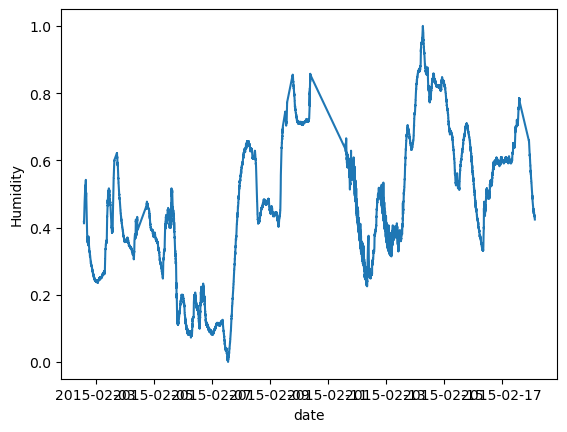

In [15]:
plt.xlabel('date')
plt.ylabel("Humidity")
plt.plot(data1)

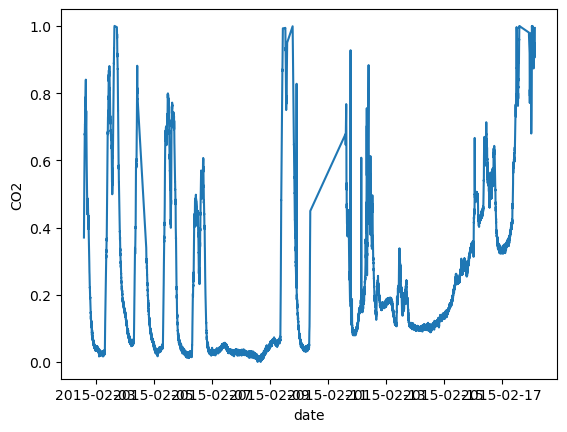

In [16]:
plt.xlabel('date')
plt.ylabel("CO2")
plt.plot(data2)

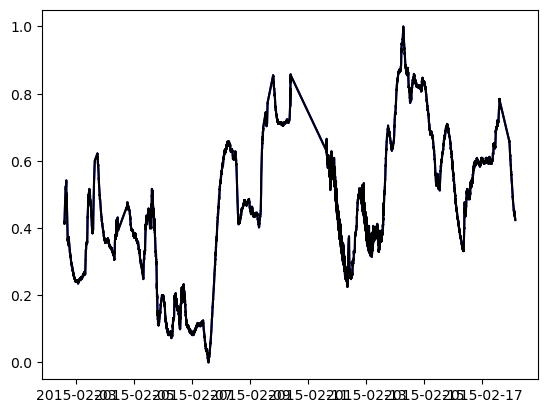

In [17]:
rol_mean = data1.rolling(window=1).mean()
rol_sd = data1.rolling(window=1).std()

plt.plot(data1,c="blue")
plt.plot(rol_mean,c="black")
plt.plot(rol_sd,c="red")

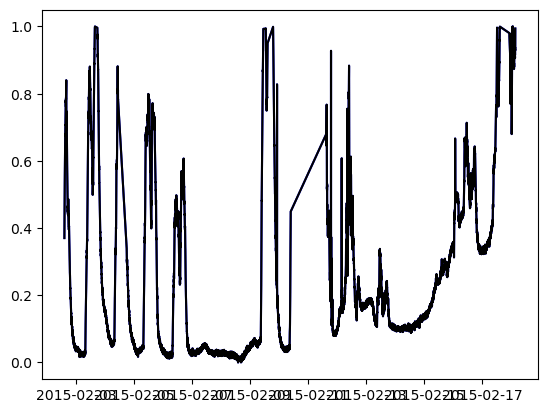

In [18]:
rol_mean = data2.rolling(window=1).mean()
rol_sd = data2.rolling(window=1).std()

plt.plot(data2,c="blue")
plt.plot(rol_mean,c="black")
plt.plot(rol_sd,c="red")

In [19]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(data2["CO2"])
print(adftest)

(-4.238699485656857, 0.0005662617134242084, 30, 19080, {'1%': -3.430692776728909, '5%': -2.8616914948646617, '10%': -2.566850636646867}, -114845.66028341025)


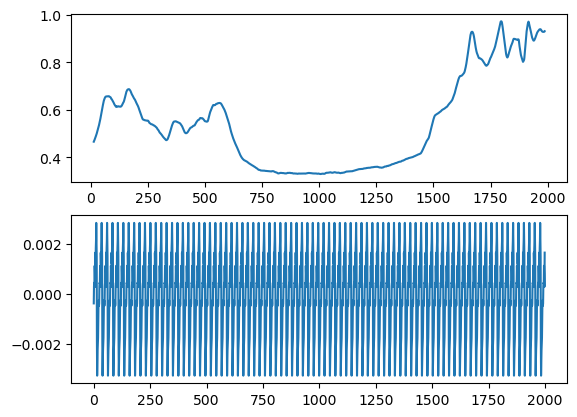

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(data2.iloc[-2000:].values,model='Additive',period=24)

trend=decompose.trend
season=decompose.seasonal

#subplot plots two graphs in one image
plt.subplot(211)
plt.plot(trend)
plt.subplot(212)
plt.plot(season)

In [21]:
data2_new = data2["CO2"]-data2["CO2"].shift(1)
data2_new

date
2015-02-02 14:19:00         NaN
2015-02-02 14:19:59    0.012325
2015-02-02 14:21:00    0.010197
2015-02-02 14:22:00    0.005594
2015-02-02 14:23:00    0.004677
                         ...   
2015-02-18 03:16:00    0.003301
2015-02-18 03:16:59   -0.001100
2015-02-18 03:17:59    0.007703
2015-02-18 03:19:00    0.019257
2015-02-18 03:20:00    0.031362
Name: CO2, Length: 19111, dtype: float64

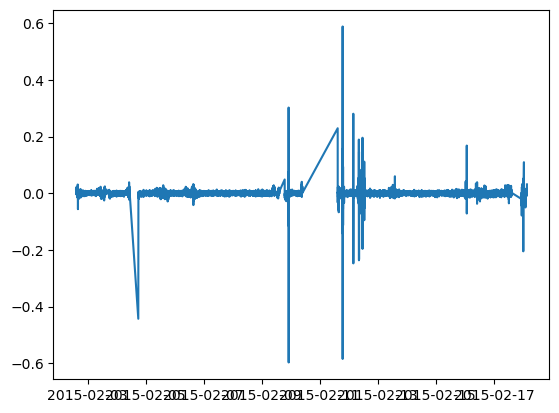

In [22]:
plt.plot(data2_new)

In [23]:
adfuller(data2_new.dropna())

(-19.26626199588859,
 0.0,
 32,
 19077,
 {'1%': -3.430692830640352,
  '5%': -2.861691518690186,
  '10%': -2.5668506493287926},
 -114822.74848041113)

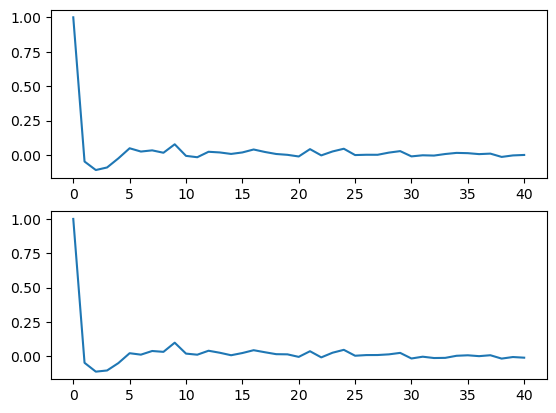

In [24]:
from statsmodels.tsa.stattools import acf,pacf

acf_plot = acf(data2_new.dropna())
pacf_plot = pacf(data2_new.dropna())

plt.subplot(211)
plt.plot(acf_plot)
plt.subplot(212)
plt.plot(pacf_plot)

In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data2_new, order=(2,2,1),seasonal_order=(2,2,1,7))
model_fit = model.fit()

C:\Users\Rhea Pandita\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Rhea Pandita\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Rhea Pandita\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Rhea Pandita\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood opti

In [26]:
res = model_fit.forecast(5)

C:\Users\Rhea Pandita\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


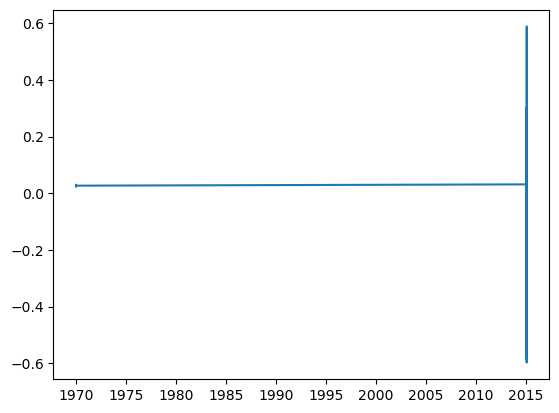

In [27]:
res = pd.DataFrame(res)
res.columns=["CO2"]
ts_data_pred = pd.DataFrame(data2_new)
ts_data_pred = ts_data_pred.append(res)

plt.plot(ts_data_pred)